## Test notebook for Data Management Acceptance Test Campaign 1

This test will be executed on the Rubin Science Platform Notebook Aspect at the U.S. Data Facility, initialized with Science Pipelines release w_2022_32.

### Test case LVV-T43: Verify implementation of Background Model Calculation

Verify that Processed Visit Images produced by the DRP and AP pipelines have had a model of the background subtracted, and that this model is persisted in a way that permits the background subtracted from any CCD to be retrieved along with the image for that CCD.

In [1]:
# Confirm that the version of the Science Pipelines is v19_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin
lsst_distrib          g0b29ad24fb+cafeaf151e 	current w_2022_32 setup


In [2]:
from lsst.daf.butler import Butler

import os
import glob
import numpy as np
import pandas as pd
import random

from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)

#### Set up plotting defaults

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
zscale = ZScaleInterval()

# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 7],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

#### Instantiate the Butler pointing to some HSC data:

In particular, this exercise will use the small `rc2_subset` dataset.

In [4]:
repo = '/sdf/group/rubin/u/jcarlin/repos/rc2_subset/SMALL_HSC'
coll = 'u/jcarlin/step4'
# Note: the ccdVisitTable resides in a separate collection because it was created after all processing was done.
table_coll = 'u/jcarlin/visit_table'
butler = Butler(repo, collections=[coll, table_coll])

Query the `ccdVisitTable` to identify all visits and detectors with available exposures.

In [5]:
visit_table = butler.get('ccdVisitTable', instrument='HSC')

In [6]:
# Check the visits that are available:
print('The repo contains the following visits: ', visit_table.visitId.unique())

The repo contains the following visits:  [  322   346   358  1178  1184  1204  1206  1214  1220  1242  1248 11690
 11694 11696 11698 11704 11710 11724 11738 11740 17900 17904 17906 17926
 17948 17950 19680 19684 19694 19696 22632 22662 23694 23704 23706 23718
 29336 29350 30482 30490]


In [7]:
# Select some visit/detector combinations from these at random:
numvisits = 100 # Number of random datarefs to select
visit_sel = visit_table.sample(numvisits)

In [8]:
visit_sel

,visitId,physical_filter,band,ra,decl,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,...,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
2338842,11694,HSC-G,g,150.096572,2.127188,52.304775,33.272629,1.847795,1274.165527,17.239981,...,2047,4175,149.999177,2.079433,149.998861,2.175081,150.194358,2.175189,150.194472,2.079339
4526450,22632,HSC-Y,y,150.115853,2.237312,37.637691,31.885647,1.477196,5650.286133,35.254375,...,2047,4175,150.018261,2.189389,150.018200,2.285187,150.213742,2.285312,150.213769,2.189345
3938841,19694,HSC-I,i,150.341430,2.035394,39.142281,33.149525,1.414283,3740.949951,30.438475,...,2047,4175,150.439054,2.083500,150.438966,1.987797,150.243631,1.987370,150.243534,2.083244
240841,1204,HSC-R,r,150.245368,2.059013,18.910133,33.593494,1.398940,2303.835938,23.291288,...,2047,4175,150.343019,2.107059,150.342869,2.011335,150.147521,2.011019,150.147470,2.106888
2340847,11704,HSC-G,g,150.797956,2.198743,46.338951,33.363197,1.832602,1404.314331,20.284658,...,2047,4175,150.891077,2.245937,150.891172,2.151719,150.703134,2.151047,150.703042,2.246234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936841,19684,HSC-I,i,150.299718,2.077071,33.592579,33.148800,1.264349,3934.579590,30.671331,...,2047,4175,150.397345,2.125189,150.397280,2.029464,150.201907,2.029035,150.201786,2.124910
236847,1184,HSC-Z,z,150.550902,2.188118,21.862238,32.227924,2.260578,2750.542725,28.267324,...,2047,4175,150.644036,2.235229,150.644055,2.141024,150.456076,2.140508,150.456045,2.235696
2338858,11694,HSC-G,g,150.096235,2.326085,52.225033,33.273861,1.847604,1264.650024,17.127501,...,2047,4175,149.998650,2.277949,149.998678,2.373600,150.194048,2.374177,150.194177,2.278293


### Check a random set of CCDs/datarefs to see whether: 
    (a) the calexpBackground corresponding to each calexp exists,
    (b) the background is populated with finite values, and
    (c) the sum of the background and the calexp image is approximately equal
        (with minor exceptions due to defects, cosmic rays, etc.) to the `postISRCCD` image.

Because it takes an extremely long time to check every CCD in the entire repo, we will randomly select a subset of datarefs to be checked (as selected using "numvisits" above).

In [9]:
bgflags = []
data_ids = []

for vis in visit_sel.itertuples():
    dataId = {'instrument':'HSC', 'detector': vis.detector, 'visit': vis.visitId, 'exposure': vis.visitId}
    if butler.datasetExists('calexp', dataId = dataId):
        calexp_bg = butler.get('calexpBackground', dataId = dataId)
        bgflags.append(np.all(np.isfinite(calexp_bg.getImage().array)))
        data_ids.append(dataId)

### Using an assert statement, confirm that _all_ background images are well-behaved.

In [10]:
assert(np.all(bgflags))
print('All CCDs have an associated background.')

All CCDs have an associated background.


### Testing - load calexp and calexpBackground and display them:

Check a few random images to see whether the background frame exists, and what it looks like.

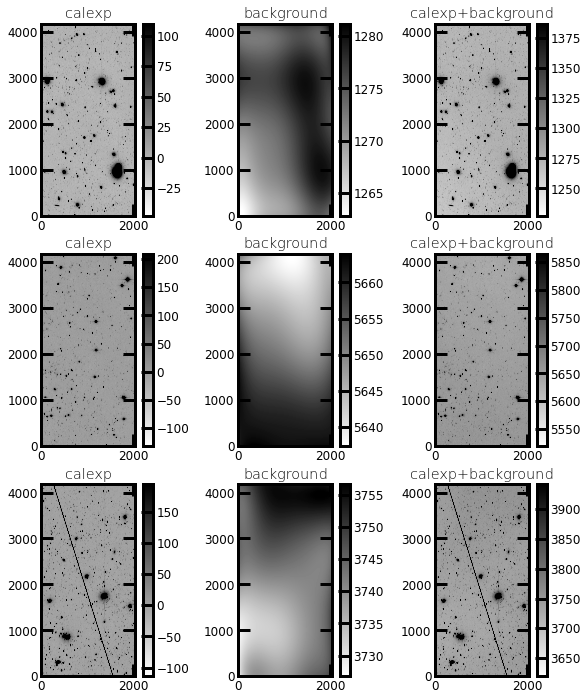

In [12]:
# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (10, 12)})
plt.rcParams.update({'font.size' : 12})

nrows = 3
f, ax = plt.subplots(nrows, 3)
axnum = 0
axs = ax.flatten()

for ii in range(nrows):
    cc = butler.get('calexp', dataId = data_ids[ii])
    bb = butler.get('calexpBackground', dataId = data_ids[ii])
    
    im = cc.image.array
    bg = bb.getImage().array
    implusbg = im + bg

    # Create an ImageNormalize object
    norm_im = ImageNormalize(im, interval=ZScaleInterval(),
                             stretch=LinearStretch())
    norm_bg = ImageNormalize(bg, interval=ZScaleInterval(),
                             stretch=LinearStretch())
    norm_implusbg = ImageNormalize(implusbg, interval=ZScaleInterval(),
                             stretch=LinearStretch())

    im0 = axs[axnum].imshow(im, norm=norm_im, origin='lower', cmap='binary')
    axs[axnum].set_title('calexp')
    plt.colorbar(im0, ax=axs[axnum])
    axnum += 1
    im1 = axs[axnum].imshow(bg, norm=norm_bg, origin='lower', cmap='binary')
    axs[axnum].set_title('background')
    plt.colorbar(im1, ax=axs[axnum])
    axnum += 1
    im2 = axs[axnum].imshow(implusbg, norm=norm_implusbg, origin='lower', cmap='binary')
    axs[axnum].set_title('calexp+background')
    plt.colorbar(im2, ax=axs[axnum])
    axnum += 1


### Test: the pixel values of the calexp+background sum should equal those of the original `postISRCCD` image

In [13]:
# Extract the images, and calculate the median pixel value from comparison of
#   postISRCCD - (calexp + background).

med_resid = []

for did in data_ids:
        postisr = butler.get('postISRCCD', dataId = dataId)
        calexp = butler.get('calexp', dataId = dataId)
        calexp_bg = butler.get('calexpBackground', dataId = dataId)
        im_postisr = postisr.image.array
        im_calexp = calexp.image.array
        im_bg = calexp_bg.getImage().array
        im_resid = im_postisr - (im_calexp + im_bg)
        med_resid.append(np.nanmedian(im_resid))

In [14]:
assert(np.allclose(med_resid, 0))
print('All images are successfully recreated as postISRCCD = calexp + calexpBackground.')

All images are successfully recreated as postISRCCD = calexp + calexpBackground.
